# Prosocial Chimps Lab 2

##### Keywords: glm, varying intercept, multiple varying intercept, posterior predictive, model averaging, model comparison

##### Data: data/chimpanzees2.csv

>The data for this example come from an experiment140 aimed at evaluating the prosocial tendencies of chimpanzees (Pan troglodytes). The experimental structure mimics many common experiments conducted on human students (Homo sapiens studiensis) by economists and psychologists. A focal chimpanzee sits at one end of a long table with two levers, one on the left and one on the right in FIGURE 10.1. On the table are four dishes which may contain desirable food items. The two dishes on the right side of the table are attached by a mechanism to the right-hand lever. The two dishes on the left side are similarly attached to the left-hand lever.

>When either the left or right lever is pulled by the focal animal, the two dishes on the same side slide towards opposite ends of the table. This delivers whatever is in those dishes to the opposite ends. In all experimental trials, both dishes on the focal animal's side contain food items. But only one of the dishes on the other side of the table contains a food item. Therefore while both levers deliver food to the focal animal, only one of the levers delivers food to the other side of the table.

>There are two experimental conditions. In the partner condition, another chimpanzee is seated at the opposite end of the table, as pictured in FIGURE 10.1. In the control condition, the other side of the table is empty. Finally, two counterbalancing treatments alternate which side, left or right, has a food item for the other side of the table. This helps detect any handedness preferences for individual focal animals. 

>When human students participate in an experiment like this, they nearly always choose the lever linked to two pieces of food, the prosocial option, but only when another student sits on the opposite side of the table. The motivating question is whether a focal chimpanzee behaves similarly, choosing the prosocial option more often when another animal is present. In terms of linear models, we want to estimate the interaction between condition (presence or absence of another animal) and option (which side is prosocial). (McElreath 292-293)



![](images/pchimps.png)

>Chimpanzee prosociality experiment, as seen from the perspective of the focal animal. The left and right levers are indicated in the foreground. Pulling either expands an accordion device in the center, pushing the food trays towards both ends of the table. Both food trays close to the focal animal have food in them. Only one of the food trays on the other side contains food. The partner condition means another animal, as pictured, sits on the other end of the table. Otherwise, the other end was empty. (McElreath 293)



## Seeing the Data

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

//anaconda/envs/py3l/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df=pd.read_csv("data/chimpanzees2.csv", sep=";")
df.head(100)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,0,0,1,2,0,1,0
1,1,0,0,1,4,0,0,1
2,1,0,0,1,6,1,0,0
3,1,0,0,1,8,0,1,0
4,1,0,0,1,10,1,1,1
5,1,0,0,1,12,1,1,1
6,1,0,0,2,14,1,0,0
7,1,0,0,2,16,1,0,0
8,1,0,0,2,18,0,1,0
9,1,0,0,2,20,0,1,0


>We're going to focus on `pulled_left` as the outcome to predict, with `prosoc_left` and `condition` as predictor variables. The outcome `pulled_left` is a 0 or 1 indicator that the focal animal pulled the left-hand lever. The predictor `prosoc_left` is a 0/1 indicator that the left-hand lever was (1) or was not (0) attached to the prosocial option, the side with two pieces of food. The `condition` predictor is another 0/1 indicator, with value 1 for the partner condition and value 0 for the control condition. (McElreath 293)

In [3]:
df.shape

(504, 8)

Lets explore the data a bit...

In [4]:
gd={}
for k, v in df.groupby('actor'):
    temp = v.groupby(['condition', 'prosoc_left'])['pulled_left'].mean()
    gd[k] = temp.values
    #print(k, ldf.values)

For each actor we get the 4 combinations of condition/prosoc_left and see what fraction of times times that chimp pulled the left lever.

In [5]:
gd

{1: array([0.33333333, 0.5       , 0.27777778, 0.55555556]),
 2: array([1, 1, 1, 1]),
 3: array([0.27777778, 0.61111111, 0.16666667, 0.33333333]),
 4: array([0.33333333, 0.5       , 0.11111111, 0.44444444]),
 5: array([0.33333333, 0.55555556, 0.27777778, 0.5       ]),
 6: array([0.77777778, 0.61111111, 0.55555556, 0.61111111]),
 7: array([0.77777778, 0.83333333, 0.94444444, 1.        ])}

## 3 different Logistic regression models

Let $P$ be the indicator for `prosoc_left`, ie is the two-food or prosocial side is the left side(1) or the right side(0). Let $C$ be the indicator for `condition`, with 1 indicating the partner condition, ie a chimp at the other end, and a 0 indicating no animal. Let $L$ (`pulled_left`) indicate with a 1 value that the left side lever is pulled and with a 0 that the right one is pulled.

### Full Model

![](images/modelfull.png)

In [6]:
def full_model():
    with pm.Model() as ps1:
        betapc = pm.Normal("betapc", 0, 10)
        betap = pm.Normal("betap", 0, 10)
        alpha = pm.Normal('alpha', 0, 10)
        logitpi = alpha + (betap + betapc*df.condition)*df.prosoc_left
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
        
    return ps1

>note that there is no main effect of $C_i$ itself, no plain beta-coefficient for condition. Why? Because there is no reason to hypothesize that the presence or absence of another animal creates a tendency to pull the left-hand lever. This is equivalent to assuming that the main effect of condition is exactly zero. You can check this assumption later, if you like.

>The priors above are chosen for lack of informativeness—they are very gently regularizing, but will be overwhelmed by even moderate evidence. So the estimates we'll get from this model will no doubt be overfit to sample somewhat. To get some comparative measure of that overfitting, we'll also fit two other models with fewer predictors. (McElreath 293-294)

### Intercept-Only Model

![](images/modelicept.png)

In [7]:
def ionly_model():
    with pm.Model() as ps0:
        alpha = pm.Normal('alpha', 0, 10)
        logitpi = alpha 
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
    return ps0

### Model using `prosoc_left` only

![](images/modelnocong.png)


In [8]:
def plonly_model():
    with pm.Model() as plonly:
        betap = pm.Normal("betap", 0, 10)
        alpha = pm.Normal('alpha', 0, 10)
        logitpi = alpha + betap*df.prosoc_left
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
    return plonly

### Sampling

Lets sample from these models

In [9]:
ionly = ionly_model()
with ionly:
    trace_ionly=pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:04<00:00, 2686.95draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124cb6438>,
      dtype=object)

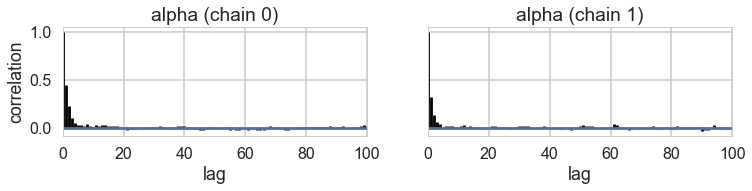

In [10]:
pm.autocorrplot(trace_ionly)

In [11]:
pm.summary(trace_ionly)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.320775,0.090363,0.001355,0.144705,0.498554,3572.66139,1.000143


In [12]:
full = full_model()
with full:
    trace_full=pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betap, betapc]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:11<00:00, 1029.49draws/s]


In [13]:
plonly = plonly_model()
with plonly:
    trace_plonly=pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betap]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1457.90draws/s]


In [14]:
pm.summary(trace_plonly)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betap,0.558683,0.183620,0.002918,0.200641,0.915314,3347.547405,1.000031
alpha,0.048649,0.127483,0.002042,-0.198586,0.300061,3306.690093,0.999903


## Model Comparison for these models

In [17]:
def make_compare(names, traces, models, method='pseudo-BMA', ic='WAIC'):
    modeldict = {m:traces[i] for i,m in enumerate(models)}
    comparedf=pm.compare(modeldict, method=method, ic=ic)
    temp=comparedf.sort_index()
    temp['Model']=names
    comparedf = temp.sort_values(ic).set_index('Model')
    return comparedf

In [18]:
names=['intercept only', 'full', 'prosocial left only']
dfc=make_compare(names, [trace_ionly, trace_full, trace_plonly],[ionly, full, plonly])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
Model,,,,,,,
prosocial left only,680.58,2.04,0,0.71,9.34,0,0
full,682.45,3.05,1.87,0.28,9.43,0.76,0
intercept only,687.95,1,7.37,0.02,7.12,6.15,0


In [78]:
dfc2=make_compare(names, [trace_ionly, trace_full, trace_plonly],[ionly, full, plonly], method='stacking')
dfc2

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
Model,,,,,,,
prosocial left only,680.58,2.04,0,0.89,9.34,0,0
full,682.45,3.05,1.87,0,9.43,0.76,0
intercept only,687.95,1,7.37,0.11,7.12,6.15,0


Notice that the full model is worse by a small amount from the `prosoc_left` only model. But see the standard error for the difference. Even if it were doubled, there is no way it would make up the distance between the two models. Why is this the case?

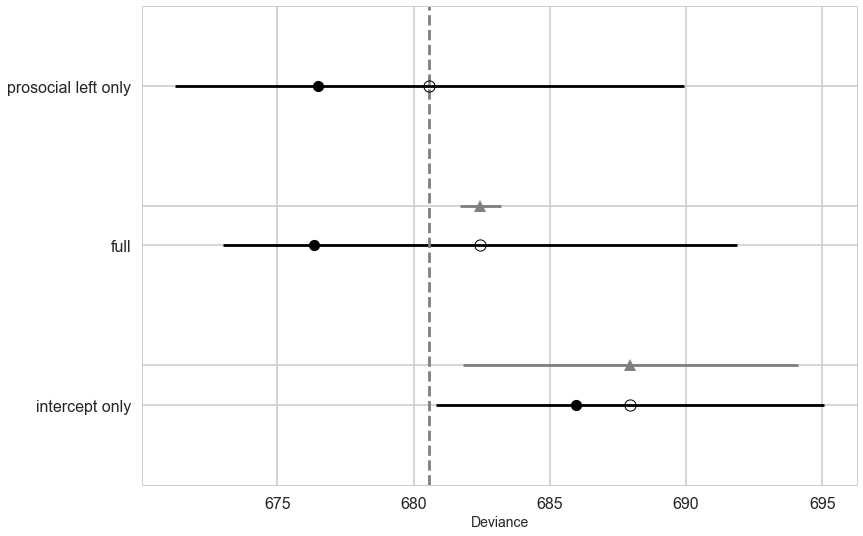

In [19]:
with sns.plotting_context('poster'):
    pm.compareplot(dfc)

In [20]:
pm.summary(trace_full)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betapc,-0.097902,0.268540,0.003460,-0.603903,0.443079,6076.631625,1.000219
betap,0.608627,0.225362,0.002922,0.182545,1.061204,5856.756129,1.000253
alpha,0.050186,0.125221,0.001413,-0.202733,0.289102,6637.952535,1.000292


>The estimated interaction effect bpC is negative, with a rather wide posterior on both sides of zero. So regardless of the information theory ranking, the estimates suggest that the chimpanzees did not care much about the other animal's presence. But they do prefer to pull the prosocial option, as indicated by the estimate for bp. (McElreath 296)

>First, let's consider the relative effect size of prosoc_left and its parameter bp. The customary measure of relative effect for a logistic model is the PROPORTIONAL CHANGE IN ODDS. You can compute the proportional odds by merely exponentiating the parameter estimate. Remember, odds are the ratio of the probability an event happens to the probability it does not happen. So in this case the relevant odds are the odds of pulling the left-hand lever (the outcome variable). If changing the predictor prosoc_left from 0 to 1 increases the log-odds of pulling the left-hand lever by 0.61 (the MAP estimate above), then this also implies that the odds are multiplied by: (McElreath 296)



In [21]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [22]:
np.exp(0.61)

1.8404313987816374

This is a 84% change in the log odds

In [23]:
invlogit(0.04), invlogit(0.04+0.61), invlogit(0.04+0.61-0.1)

(0.5099986668799655, 0.6570104626734988, 0.6341355910108007)

In [29]:
def trace_or_zero(trace, name):
    if name in trace.varnames:
        return trace[name]
    else:
        return np.zeros(2*len(trace))

In [33]:
def model_pp(gridx, tracedict):
    temp = tracedict['alpha'] + gridx['P']*(tracedict['betap'] + tracedict['betapc']*gridx['C'])
    return temp

In [34]:
def compute_pp(lpgrid, trace, tsize, paramnames, sampdistrib, invlink, inner_pp):
    tdict={}
    for pn in paramnames:
        tdict[pn] = trace_or_zero(trace, pn)
    print(tdict.keys(), tsize)
    tl=tsize
    gl=len(lpgrid)
    pp = np.empty((gl, tl))
    for i, v in enumerate(lpgrid):
        temp = inner_pp(lpgrid[i], tdict)
        pp[i,:] = sampdistrib(invlink(temp))
    return pp

In [42]:
from scipy.stats import binom
def ls_outa7(p_array):
    ppdivisor=7
    return binom.rvs(ppdivisor, p=p_array)

In [47]:
from scipy.stats import bernoulli
def ls_perrow(p_array):
    return bernoulli.rvs(p=p_array)

## Ensemble the model

In [37]:
for m in dfc.index:
    print(m)

prosocial left only
full
intercept only


In [38]:
modeldict={
    "prosocial left only": trace_plonly,
    "full": trace_full,
    "intercept only": trace_ionly
}

In [39]:
def ensemble(grid, modeldict, paramnames, comparedf, like):
    accum_pp=0
    accum_weight=0
    for m in comparedf.index:
        weight = comparedf.loc[m]['weight']
        print(m, "size", len(modeldict[m]))
        pp=compute_pp(grid, modeldict[m], 2*len(modeldict[m]), paramnames, like, invlogit, model_pp)
        print(m, weight, np.median(pp))
        accum_pp += pp*weight
        accum_weight +=weight
    return accum_pp/accum_weight

In [40]:
import itertools
psleft = [0,1]
condition = [0,1]
xgrid = [{'C':v[0], 'P':v[1]} for v in itertools.product(condition, psleft)]

In [43]:
ppens = ensemble(xgrid, modeldict, ['alpha', 'betap', 'betapc'], dfc, ls_outa7)

prosocial left only size 5000
dict_keys(['alpha', 'betap', 'betapc']) 10000
prosocial left only 0.71 4.0
full size 5000
dict_keys(['alpha', 'betap', 'betapc']) 10000
full 0.28 4.0
intercept only size 5000
dict_keys(['alpha', 'betap', 'betapc']) 10000
intercept only 0.02 4.0


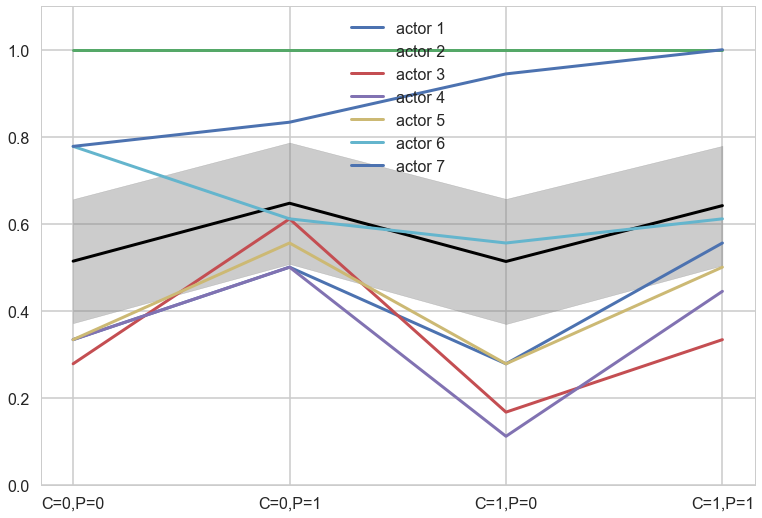

In [45]:
ppdivisor=7
with sns.plotting_context('poster'):
    meanpp, stdpp = ppens.mean(axis=1), ppens.std(axis=1)
    fmt = lambda d: ",".join([e+"="+str(d[e]) for e in d])
    plt.plot(range(4),meanpp/ppdivisor, lw=3, color="black")
    for i, chimp in enumerate(gd):
        plt.plot(range(4), gd[chimp], label="actor {}".format(chimp), lw=3)
    plt.fill_between(range(4), (meanpp-stdpp)/ppdivisor, (meanpp+stdpp)/ppdivisor, alpha=0.4, color="gray")
    plt.ylim([0,1.1])
    plt.xticks(range(4),[fmt(e) for e in xgrid])
    plt.legend();

In [48]:
ppens = ensemble(xgrid, modeldict, ['alpha', 'betap', 'betapc'], dfc, ls_perrow)

prosocial left only size 5000
dict_keys(['alpha', 'betap', 'betapc']) 10000
prosocial left only 0.71 1.0
full size 5000
dict_keys(['alpha', 'betap', 'betapc']) 10000
full 0.28 1.0
intercept only size 5000
dict_keys(['alpha', 'betap', 'betapc']) 10000
intercept only 0.02 1.0


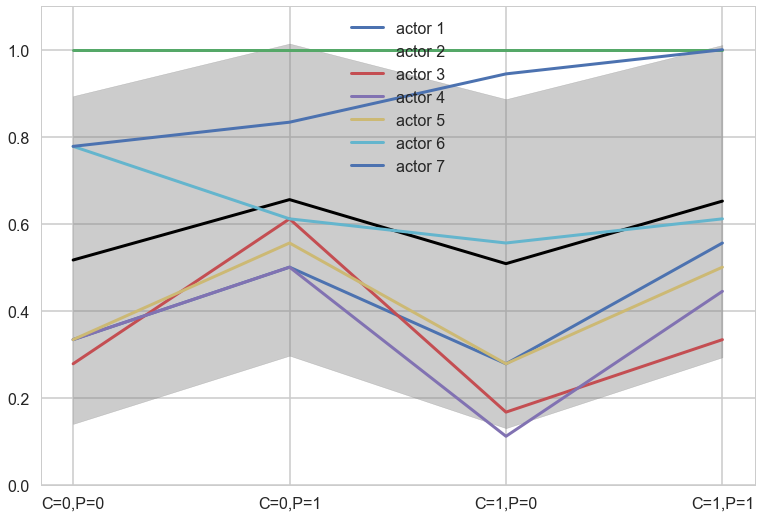

In [49]:
ppdivisor=1
with sns.plotting_context('poster'):
    meanpp, stdpp = ppens.mean(axis=1), ppens.std(axis=1)
    fmt = lambda d: ",".join([e+"="+str(d[e]) for e in d])
    plt.plot(range(4),meanpp/ppdivisor, lw=3, color="black")
    for i, chimp in enumerate(gd):
        plt.plot(range(4), gd[chimp], label="actor {}".format(chimp), lw=3)
    plt.fill_between(range(4), (meanpp-stdpp)/ppdivisor, (meanpp+stdpp)/ppdivisor, alpha=0.4, color="gray")
    plt.ylim([0,1.1])
    plt.xticks(range(4),[fmt(e) for e in xgrid])
    plt.legend();

In [80]:
ppens2 = ensemble(xgrid, modeldict, ['alpha', 'betap', 'betapc'], dfc2, ls_perrow)

prosocial left only size 5000
dict_keys(['alpha', 'betap', 'betapc']) 10000
prosocial left only 0.89 1.0
full size 5000
dict_keys(['alpha', 'betap', 'betapc']) 10000
full 0.0 1.0
intercept only size 5000
dict_keys(['alpha', 'betap', 'betapc']) 10000
intercept only 0.11 1.0


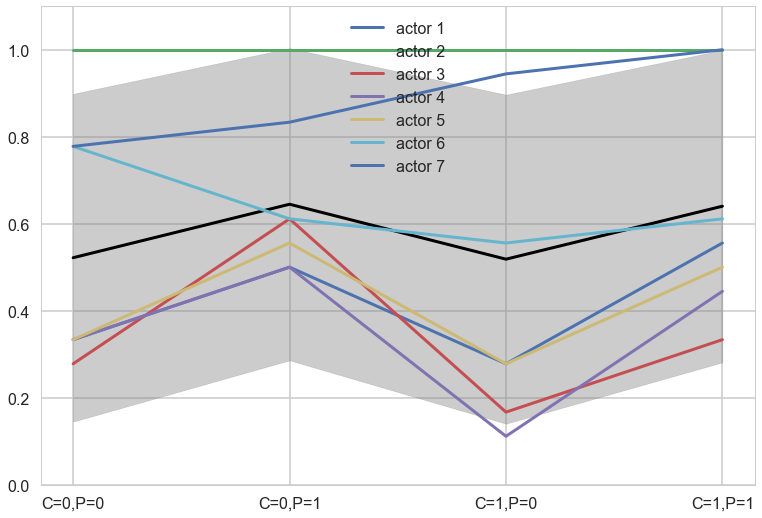

In [81]:
ppdivisor=1
with sns.plotting_context('poster'):
    meanpp, stdpp = ppens2.mean(axis=1), ppens.std(axis=1)
    fmt = lambda d: ",".join([e+"="+str(d[e]) for e in d])
    plt.plot(range(4),meanpp/ppdivisor, lw=3, color="black")
    for i, chimp in enumerate(gd):
        plt.plot(range(4), gd[chimp], label="actor {}".format(chimp), lw=3)
    plt.fill_between(range(4), (meanpp-stdpp)/ppdivisor, (meanpp+stdpp)/ppdivisor, alpha=0.4, color="gray")
    plt.ylim([0,1.1])
    plt.xticks(range(4),[fmt(e) for e in xgrid])
    plt.legend();

## A heirarchical model

>Now back to modeling individual variation. There is plenty of evidence of handedness in these data. Four of the individuals tend to pull the right-hand lever, across all treatments. Three individuals tend to pull the left across all treatments. One individual, actor number 2, always pulled the left-hand lever, regardless of treatment. That's the horizontal green line at the top (McElreath 299)

>Think of handedness here as a masking variable. If we can model it well, maybe we can get a better picture of what happened across treatments. So what we wish to do is estimate handedness as a distinct intercept for each individual, each actor. You could do this using a dummy variable for each individual. But it'll be more convenient to use a vector of intercepts, one for each actor. This form is equivalent to making dummy variables, but it is more compact  (McElreath 299)


Here we have a varying intercepts model

![](images/multichimp.png)

In [50]:
def vi_model():
    with pm.Model() as vi:
        betapc = pm.Normal("betapc", 0, 10)
        betap = pm.Normal("betap", 0, 10)
        alpha = pm.Normal('alpha', 0, 10)
        sigma_actor = pm.HalfCauchy("sigma_actor", 1)
        alpha_actor = pm.Normal('alpha_actor', 0, sigma_actor, shape=7)
        logitpi = alpha + alpha_actor[df.index//72] + (betap + betapc*df.condition)*df.prosoc_left
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
        
    return vi

In [51]:
vi = vi_model()
with vi:
    step=pm.NUTS(target_accept=0.95)
    vi_trace=pm.sample(10000, tune=4000, step=step)

//anaconda/envs/py3l/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
//anaconda/envs/py3l/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_actor, sigma_actor, alpha, betap, betapc]
Sampling 2 chains: 100%|██████████| 28000/28000 [04:48<00:00, 97.21draws/s] 
The number of effective samples

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


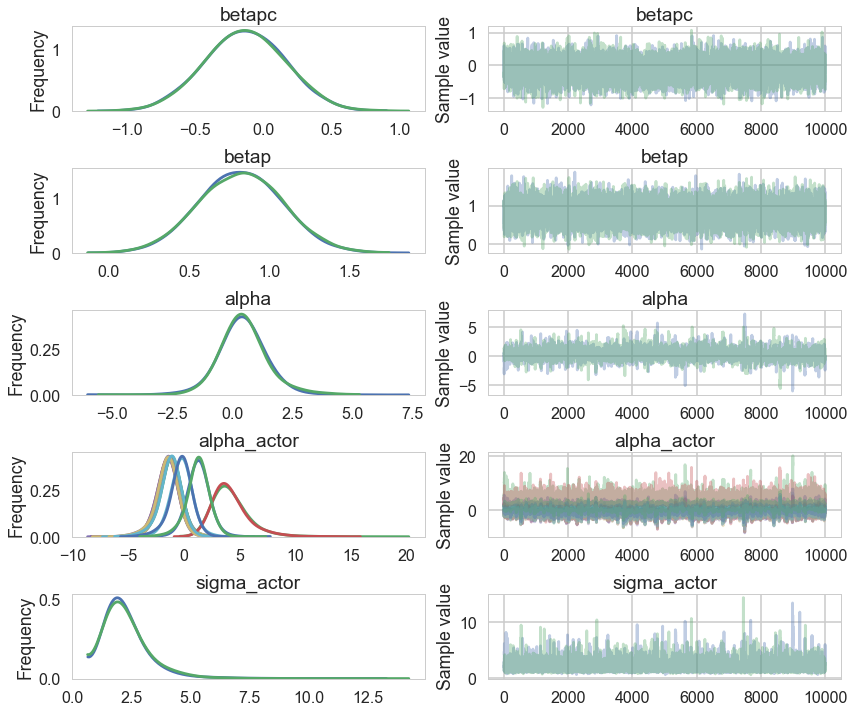

In [53]:
pm.traceplot(vi_trace);

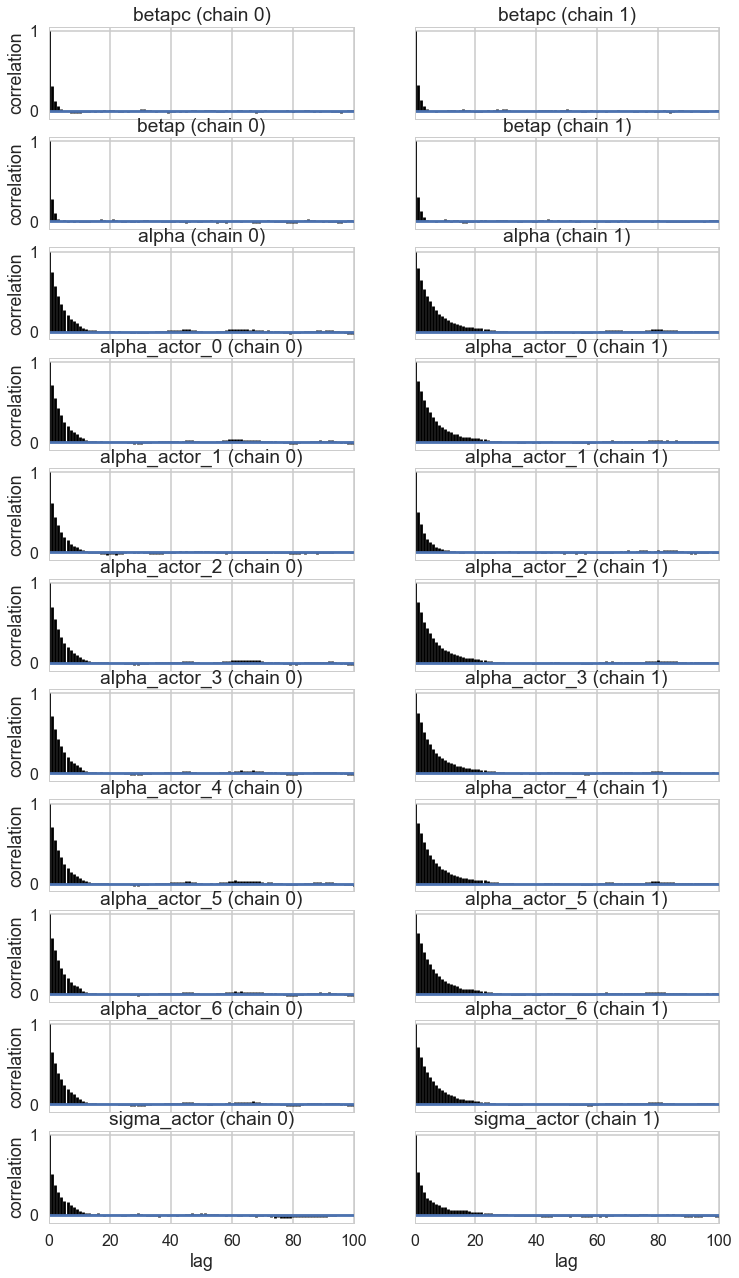

In [54]:
pm.autocorrplot(vi_trace);

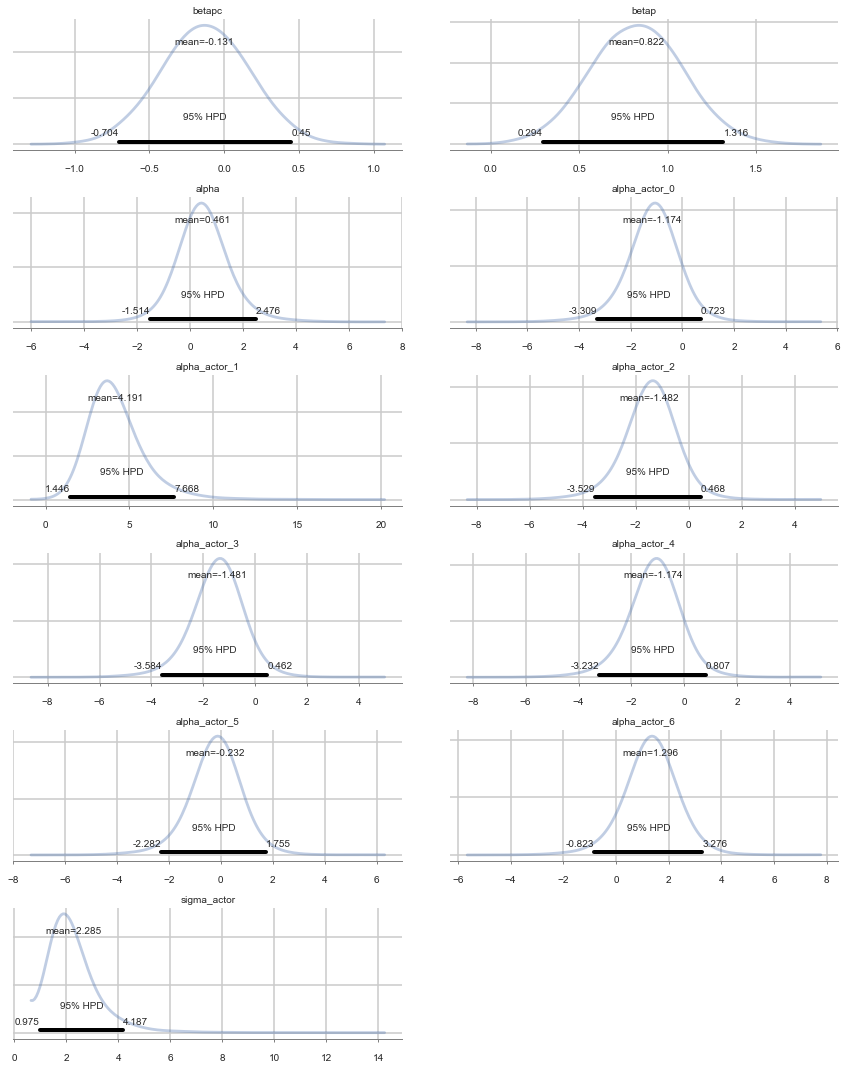

In [55]:
pm.plot_posterior(vi_trace, kde_plot=True);

Positive values of `alpha_actor` indicate a preference for the left side.

>You can see that there is strong skew here. Plausible values of `alpha_actor__1` are always positive, indicating a left-hand bias. But the range of plausible values is truly enormous. What has happened here is that many very large positive values are plausible, because actor number 2 always pulled the left-hand lever (McElreath 300)



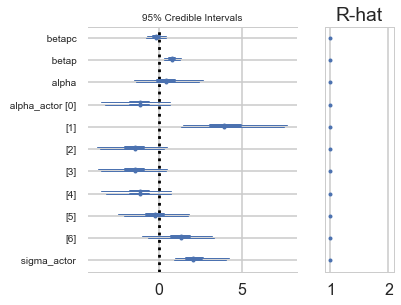

In [56]:
pm.forestplot(vi_trace);

In [57]:
pm.summary(vi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betapc,-0.131208,0.296381,0.002926,-0.703957,0.449887,9641.703222,0.999970
betap,0.822480,0.261657,0.002697,0.294169,1.316371,10254.329922,0.999974
alpha,0.461173,0.992565,0.020469,-1.514374,2.475734,2122.263430,1.000586
alpha_actor__0,-1.174212,1.009754,0.020329,-3.308787,0.722989,2206.220102,1.000701
alpha_actor__1,4.190796,1.683419,0.026690,1.446012,7.667930,3873.114930,0.999993
alpha_actor__2,-1.481770,1.010604,0.020473,-3.529280,0.467687,2203.193524,1.000631
alpha_actor__3,-1.480606,1.011652,0.020609,-3.583637,0.461815,2174.896491,1.000613
alpha_actor__4,-1.173902,1.008305,0.020495,-3.232051,0.806559,2210.093003,1.000564
alpha_actor__5,-0.231975,1.009792,0.020419,-2.282377,1.755007,2201.283238,1.000633
alpha_actor__6,1.296190,1.029850,0.020449,-0.822919,3.275823,2328.638386,1.000418


In [58]:
vi_trace['alpha_actor'][:,1].shape

(20000,)

### Predictives are on individuals now

>You can best appreciate the way these individual intercepts influence fit by plotting posterior predictions again. The code below just modifies the code from earlier to show only a single individual, the one specified by the first line.  (McElreath 301)



In [59]:
def like_sample_hier(p_array):
    return bernoulli.rvs(p=p_array)

In [60]:
def model_pp_hier(gridx, tracedict, ix):
    temp = tracedict['alpha'] + tracedict['alpha_actor'][:,ix]+gridx['P']*(tracedict['betap'] + tracedict['betapc']*gridx['C'])
    return temp

In [61]:
def compute_pp2(lpgrid, trace, paramnames, sampdistrib, invlink, inner_pp, ix):
    tdict=trace
    tl=2*len(trace)
    gl=len(lpgrid)
    pp = np.empty((gl, tl))
    for i, v in enumerate(lpgrid):
        temp = inner_pp(lpgrid[i], tdict, ix)
        pp[i,:] = invlink(temp)
    return pp

In [62]:
vi_trace.varnames

['betapc', 'betap', 'alpha', 'sigma_actor_log__', 'alpha_actor', 'sigma_actor']

In [63]:
vnames=['betapc', 'betap', 'alpha', 'alpha_actor']
pphier0=compute_pp2(xgrid, vi_trace, vnames, like_sample_hier, invlogit, model_pp_hier, 0)

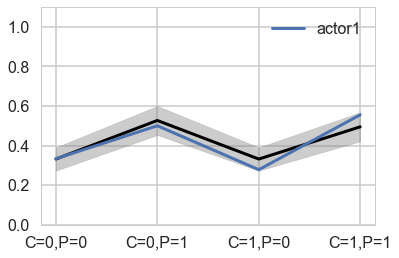

In [64]:
ppdivisor=1
meanpp, stdpp = pphier0.mean(axis=1), pphier0.std(axis=1)
fmt = lambda d: ",".join([e+"="+str(d[e]) for e in d])
plt.plot(range(4),meanpp/ppdivisor, lw=3, color="black")
plt.plot(range(4), gd[1], label="actor{}".format(1), lw=3)
plt.fill_between(range(4), (meanpp-stdpp)/ppdivisor, (meanpp+stdpp)/ppdivisor, alpha=0.4, color="gray")
plt.ylim([0,1.1])
plt.xticks(range(4),[fmt(e) for e in xgrid])
plt.legend();

In [65]:
pphier6=compute_pp2(xgrid, vi_trace, vnames, like_sample_hier, invlogit, model_pp_hier, 6)

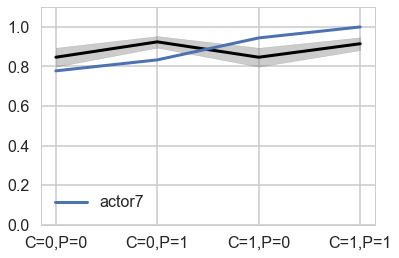

In [66]:
ppdivisor=1
meanpp, stdpp = pphier6.mean(axis=1), pphier6.std(axis=1)
fmt = lambda d: ",".join([e+"="+str(d[e]) for e in d])
plt.plot(range(4),meanpp/ppdivisor, lw=3, color="black")
plt.plot(range(4), gd[7], label="actor{}".format(7), lw=3)
plt.fill_between(range(4), (meanpp-stdpp)/ppdivisor, (meanpp+stdpp)/ppdivisor, alpha=0.4, color="gray")
plt.ylim([0,1.1])
plt.xticks(range(4),[fmt(e) for e in xgrid])
plt.legend();

>Notice that these individual intercepts do help the model fit the overall level for each chimpanzee. But they do not change the basic zig-zag prediction pattern across treatments. (McElreath 302)

## Varying experimental blocks as well

>The kind of data structure here is usually called a CROSS-CLASSIFIED multilevel model. It is cross-classified, because actors are not nested within unique blocks. If each chimpanzee had instead done all of his or her pulls on a single day, within a single block, then the data structure would instead be hierarchical. However, the model specification would typically be the same. So the model structure and code you'll see below will apply both to cross-classified designs and hierarchical designs. Other software sometimes forces you to treat these differently, on account of using a conditioning engine substantially less capable than MCMC. There are other types of “hierarchical” multilevel models, types that make adaptive priors for adaptive priors. It's turtles all the way down, recall (page 13). You'll see an example in the next chapter. But for the most part, people (or their software) nearly always use the same kind of model in both cases. (McElreath 371)

>Each pull is within a cluster of pulls belonging to an individual chimpanzee. But each pull is also within an experimental block, which represents a collection of observations that happened on the same day. So each observed pull belongs to both an actor (1 to 7) and a block (1 to 6). There may be unique intercepts for each actor as well as for each block. (McElreath 370-371)

>To add the second cluster type, block, we merely replicate the structure for the actor cluster. This means the linear model gets yet another varying intercept, $α_{BLOCK[i]}$, and the model gets another adaptive prior and yet another standard deviation parameter.  Here is the mathematical form of the model, with the new pieces of the machine highlighted in blue: (McElreath 372-373)


![](images/multichimpcluster.png)

>Each cluster variable needs its own standard deviation parameter that adapts the amount of pooling across units, be they actors or blocks. These are αACTOR and αBLOCK, respectively. Finally, note that there is only one global mean parameter α, and both of the varying intercept parameters are centered at zero. We can't identify a separate mean for each varying intercept type, because both intercepts are added to the same linear prediction. So it is conventional to define varying intercepts with a mean of zero, so there's no risk of accidentally creating hard-to-identify parameters.  (McElreath 373)


In [67]:
df.head(50)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,0,0,1,2,0,1,0
1,1,0,0,1,4,0,0,1
2,1,0,0,1,6,1,0,0
3,1,0,0,1,8,0,1,0
4,1,0,0,1,10,1,1,1
5,1,0,0,1,12,1,1,1
6,1,0,0,2,14,1,0,0
7,1,0,0,2,16,1,0,0
8,1,0,0,2,18,0,1,0
9,1,0,0,2,20,0,1,0


In [68]:
def viplusblock_model():
    with pm.Model() as vipb:
        betapc = pm.Normal("betapc", 0, 10)
        betap = pm.Normal("betap", 0, 10)
        alpha = pm.Normal('alpha', 0, 10)
        sigma_actor = pm.HalfCauchy("sigma_actor", 1)
        sigma_block = pm.HalfCauchy("sigma_block", 1)
        alpha_actor = pm.Normal('alpha_actor', 0, sigma_actor, shape=7)
        alpha_block = pm.Normal('alpha_block', 0, sigma_block, shape=6)
        logitpi = alpha + alpha_actor[df.index//72] + alpha_block[df.block.values -1]+ (betap + betapc*df.condition)*df.prosoc_left
        o = pm.Bernoulli("pulled_left", p=pm.math.invlogit(logitpi), observed=df.pulled_left)
        
    return vipb

In [69]:
vipb=viplusblock_model()
with vipb:
    step=pm.NUTS(target_accept=0.95)
    trace_vipb = pm.sample(10000, tune=4000, step=step)

//anaconda/envs/py3l/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
//anaconda/envs/py3l/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_block, alpha_actor, sigma_block, sigma_actor, alpha, betap, betapc]
Sampling 2 chains: 100%|██████████| 28000/28000 [07:39<00:00, 60.99draws/s] 
There

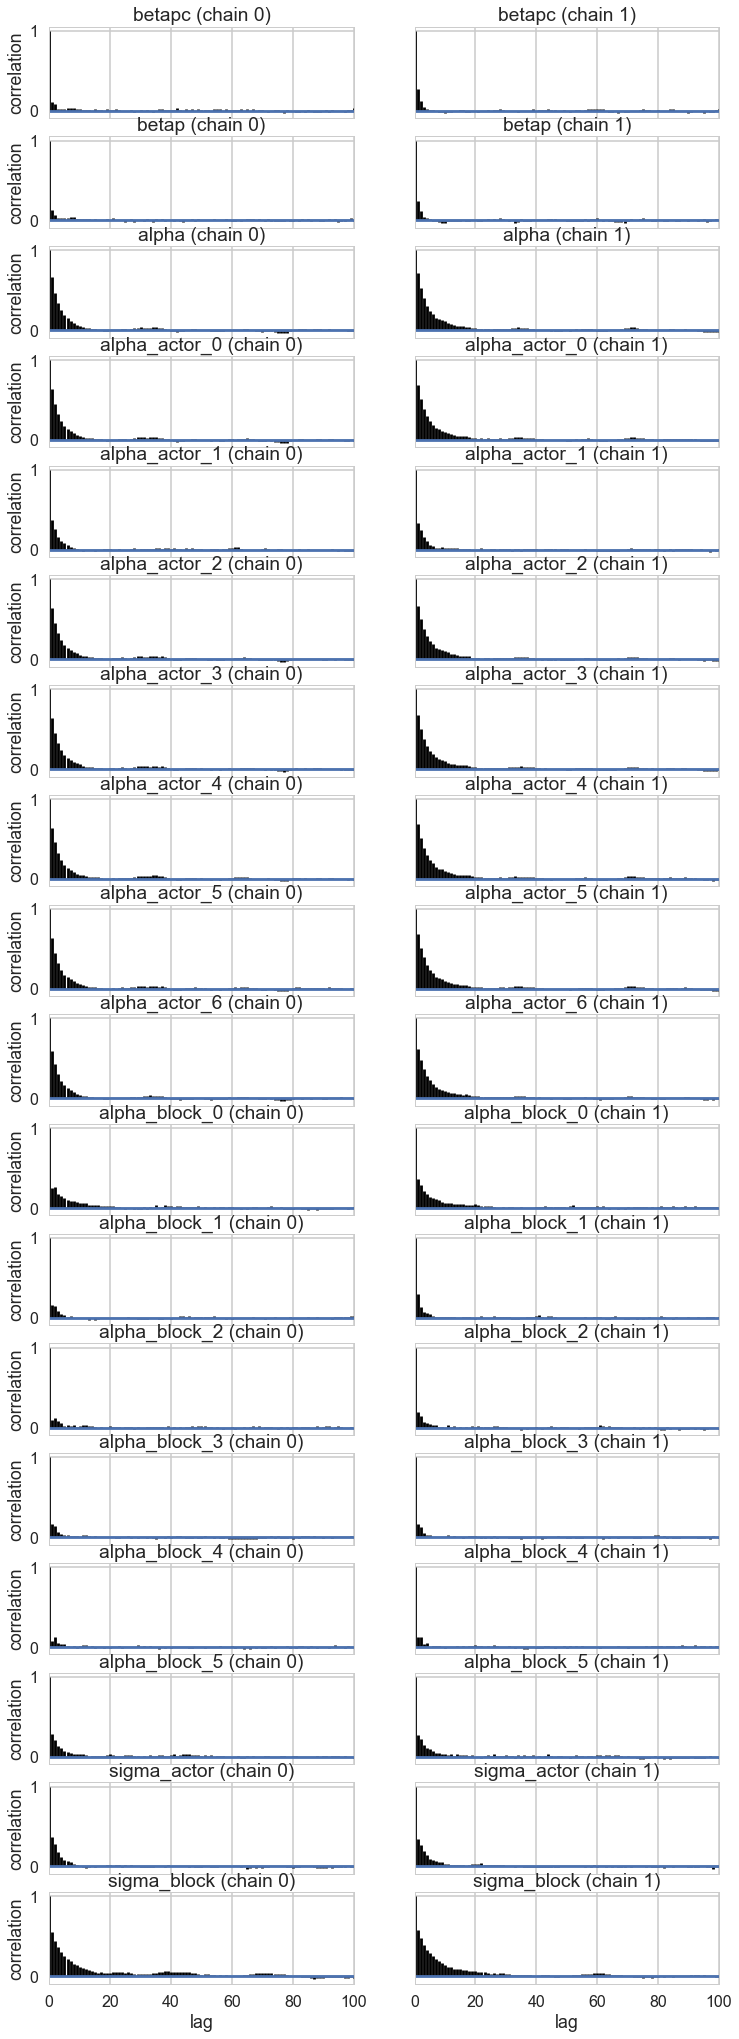

In [70]:
pm.autocorrplot(trace_vipb);

In [71]:
pm.summary(trace_vipb)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betapc,-0.136661,0.298732,0.003205,-0.714393,0.456498,10858.476186,1.000249
betap,0.827471,0.263371,0.002686,0.306285,1.331519,10928.829743,0.999985
alpha,0.441206,0.955764,0.019745,-1.334696,2.446102,2731.694987,1.000219
alpha_actor__0,-1.155615,0.963285,0.019898,-3.189305,0.643951,2836.941086,1.000116
alpha_actor__1,4.181831,1.614984,0.022713,1.537775,7.552081,6213.691372,1.000122
alpha_actor__2,-1.467761,0.970631,0.020526,-3.413624,0.399218,2681.059595,1.000311
alpha_actor__3,-1.467665,0.967424,0.020309,-3.412197,0.407168,2733.707926,1.000252
alpha_actor__4,-1.159011,0.965639,0.020258,-3.168069,0.652352,2725.947764,1.000179
alpha_actor__5,-0.207750,0.961660,0.019546,-2.164942,1.642717,2804.582399,1.000275
alpha_actor__6,1.334270,0.985756,0.019454,-0.650522,3.318570,2924.966948,1.000006


>First, notice that the number of effective samples, n_eff, varies quite a lot across parameters. This is common in complex models. Why? There are many reasons for this. But in this sort of model the most common reason is that some parameter spends a lot of time near a boundary. Here, that parameter is sigma_block. It spends a lot of time near its minimum of zero. As a consequence, you may also see a warning about “divergent iterations.”  (McElreath 374)

GridSpec(1, 2, width_ratios=[3, 1])

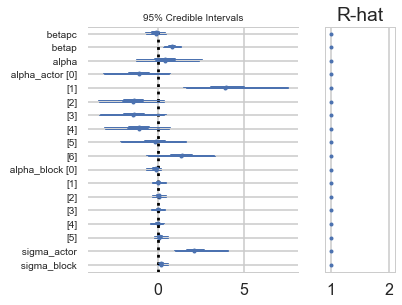

In [72]:
pm.forestplot(trace_vipb)

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


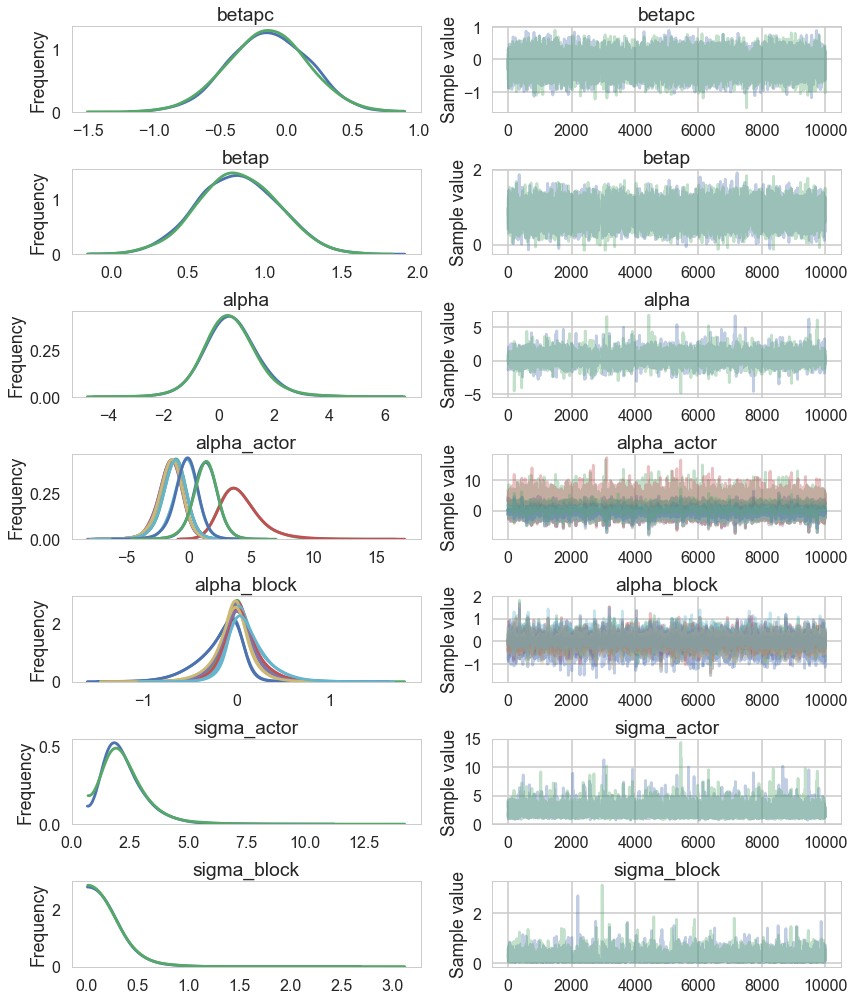

In [73]:
pm.traceplot(trace_vipb);

>While there's uncertainty about the variation among actors, this model is confident that actors vary more than blocks. You can easily see this variation in the varying intercept estimates: the a_actor distributions are much more scattered than are the a_block distributions. (McElreath 374-375)

Notice that the trace of the $\sigma_{ACTOR}$ is way wider.

>compare sigma_actor to sigma_block and notice that the estimated variation among actors is a lot larger than the estimated variation among blocks. This is easy to appreciate, if we plot the marginal posterior distributions of these  (McElreath 374)

//anaconda/envs/py3l/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(-1, 10)

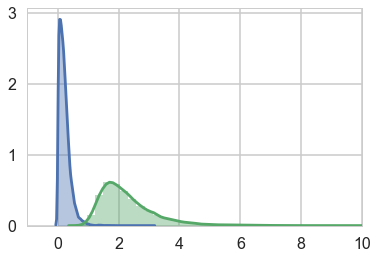

In [74]:
sns.distplot(trace_vipb['sigma_block'])
sns.distplot(trace_vipb['sigma_actor']);
plt.xlim([-1,10])

## Model Comparison

Lets compare the WAICs of the actor block and cross-classified model.

>While the cross-classified model has 7 more parameters than the actor block model does, it has only about 2.5 more effective parameters. Why? Because the posterior distribution for sigma_block ended up close to zero. This means each of the 6 a_block parameters is strongly shrunk towards zero—they are relatively inflexible. In contrast, the a_actor parameters are shrunk towards zero much less, because the estimated variation across actors is much larger, resulting in less shrinkage. But as a consequence, each of the a_actor parameters contributes much more to the pWAIC value. (McElreath 375)



In [82]:
dfc3=make_compare(['actor-multilevel', 'actor-block-crossclassified'], [vi_trace, trace_vipb],[vi, vipb])

//anaconda/envs/py3l/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [83]:
dfc3

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
Model,,,,,,,
actor-multilevel,531.24,8.06,0,0.67,19.47,0,0
actor-block-crossclassified,532.66,10.37,1.42,0.33,19.69,1.73,0


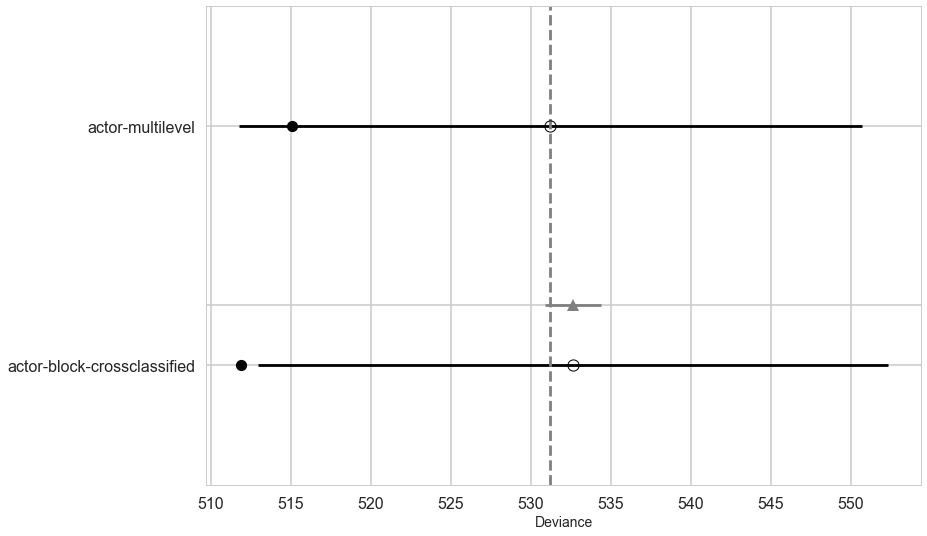

In [84]:
with sns.plotting_context('poster'):
    pm.compareplot(dfc3)

>You might also notice that the difference in WAIC between these models is small, only 1.2. This is especially small compared the standard deviation of the difference, 1.94. These two models imply nearly identical predictions, and so their expected out-of-sample accuracy is nearly identical. The block parameters have been shrunk so much towards zero that they do very little work in the model.

>If you are feeling the urge to “select” the actor block model as the best model, pause for a moment. There is nothing to gain here by selecting either model. The comparison of the two models tells a richer story—whether we include block or not hardly matters, and the a_block and sigma_block estimates tell us why. Furthermore, the standard error of the difference in WAIC between the models is twice as large as the difference itself. By retaining and reporting both models, we and our readers learn more about the experiment. (McElreath 375-376)

### Posterior Predictives

There are now 2 kinds of posterior predicties here, just as we saw in the rat tumor problem.

>Before computing predictions, note that we should no longer expect the posterior predictive distribution to match the raw data, even when the model worked correctly. Why? The whole point of partial pooling is to shrink estimates towards the grand mean. So the estimates should not necessarily match up with the raw data, once you use pooling. (McElreath 377)

The first kind is the usual, say within an actor block, new posterior predictives.

The second kind, is for a new blockor new chimp (like the 71st experiment)

>Often, the particular clusters in the sample are not of any enduring interest. In the chimpanzees data, for example, these particular 7 chimpanzees are just seven individuals. We'd like to make inferences about the whole species, not just those seven individuals. So the individual actor intercepts aren't of interest, but the distribution of them definitely is.

>One way to grasp the task of construction posterior predictions for new clusters is to imagine leaving out one of the clusters when you fit the model to the data. For example, suppose we leave out actor number 7 when we fit the chimpanzees model. Now how can we assess the model's accuracy for predicting actor number 7's behavior? We can't use any of the a_actor parameter estimates, because those apply to other individuals. But we can make good use of the a and sigma_actor parameters, because those describe the population of actors. (McElreath 378)

Here too, there are multiple predictives you can create:

(1) predictive for an average actor.

>First, let's see how to construct posterior predictions for a now, previously unobserved average actor. By “average,” I mean an individual chimpanzee with an intercept exactly at a (α), the population mean. This simultaneously implies a varying intercept of zero. Since there is uncertainty about the population mean, there is still uncertainty about this average individual's intercept. But as you'll see, the uncertainty is much smaller than it really should be, if we wish to honestly represent the problem of what to expect from a new individual. (McElreath 378)

(2) prediction for an individual actor.

Draw a new $\alpha_{ACTOR} \sim N(0, \sigma_{ACTOR})$. Thus given a $\sigma_{ACTOR}$ trace we can get new probability traces. Here we can make two plots

1. A line for each sample over the grid. Since we are sampling $\alpha_{ACTOR}$ separately each time, we get a "new" chimp each time. Note that what we are doing here is removing the varying effects term and replacing it by this sample.
2. a marginal which now takes all these actor samples, and adds them in to get probability samples and then just passes these through the link to get proportions pulling left. This is the usual posterior predictive.